# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
from datetime import datetime

# Data

## Dados cadastrais

In [2]:
info_cadastro = pd.read_csv('../data/fundos/cad_fi.csv', encoding='ISO-8859-1', sep=';')

/tmp/ipykernel_17022/4102126748.py:1: DtypeWarning: Columns (14,17,18,20,22,24,27,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  info_cadastro = pd.read_csv('../data/fundos/cad_fi.csv', encoding='ISO-8859-1', sep=';')


## Histórico

In [34]:
# Último mês completo
fundos_2022_12 = pd.read_csv('../data/fundos/inf_diario/inf_diario_fi_2022/inf_diario_fi_202212.csv', 
                             encoding='ISO-8859-1', sep=';')

In [35]:
# Média de 2000 cotistas em Dezembro de 2022
cnpj_valido = fundos_2022_12.groupby('CNPJ_FUNDO').mean(numeric_only=True).query('NR_COTST >= 1000').index
len(cnpj_valido)

1540

In [36]:
# Leitura do histórico
df_fundos = pd.DataFrame()
paths = glob.glob('../data/fundos/inf_diario/*')
for path in paths:
    files = glob.glob(f'{path}/*.csv')
    for file in files:
        df_temp = pd.read_csv(file, encoding='ISO-8859-1', sep=';')
        df_temp = df_temp[df_temp['CNPJ_FUNDO'].isin(cnpj_valido)]
        df_fundos = pd.concat([df_fundos, df_temp])

In [37]:
# Conversão de data
df_fundos['DT_COMPTC'] = pd.to_datetime(df_fundos['DT_COMPTC'])

In [38]:
# Adição da denominação social
df_fundos_nominacao = df_fundos.merge(info_cadastro[['CNPJ_FUNDO', 'DENOM_SOCIAL']], how='left', on='CNPJ_FUNDO')

In [39]:
# Ordenando pela denominação social e data
df_fundos_nominacao.sort_values(['DENOM_SOCIAL', 'DT_COMPTC'], inplace=True)

In [40]:
# Exclusão dos fundos com denominação social igual a nan
df_fundos_nominacao_valido = df_fundos_nominacao[~df_fundos_nominacao['DENOM_SOCIAL'].isna()].copy()

In [41]:
# Resetando o index
df_fundos_nominacao_valido.reset_index(drop=True, inplace=True)

In [42]:
print(f'Before drop duplicated: {df_fundos_nominacao_valido.shape[0]}')
df_fundos_nominacao_valido.drop_duplicates(inplace=True)
print(f'After drop duplicated: {df_fundos_nominacao_valido.shape[0]}')

Before drop duplicated: 1901142
After drop duplicated: 1493579


In [43]:
print('Check duplicates')
df_fundos_nominacao_valido[df_fundos_nominacao_valido.duplicated()]

Check duplicates


,CNPJ_FUNDO,DT_COMPTC,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST,TP_FUNDO,DENOM_SOCIAL


In [44]:
# Histórico exemplo
aux = df_fundos_nominacao_valido[df_fundos_nominacao_valido['CNPJ_FUNDO'] == '00.601.692/0001-23']

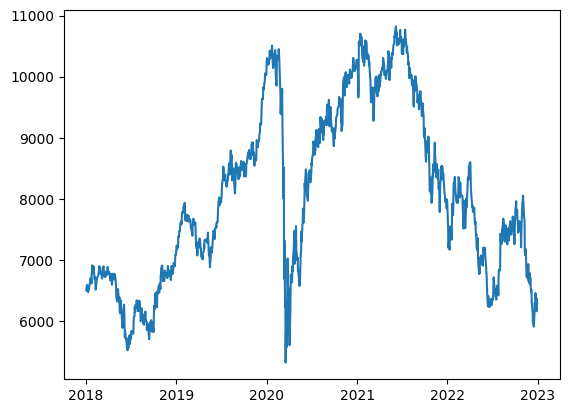

In [45]:
plt.plot(aux['DT_COMPTC'], aux['VL_QUOTA'])

# Data Output

In [46]:
# Renomeação das colunas
df_fundos_nominacao_valido.columns = df_fundos_nominacao_valido.columns.str.lower()

In [47]:
# Dados disponível
df_fundos_nominacao_valido.columns

Index(['cnpj_fundo', 'dt_comptc', 'vl_total', 'vl_quota', 'vl_patrim_liq',
       'captc_dia', 'resg_dia', 'nr_cotst', 'tp_fundo', 'denom_social'],
      dtype='object')

In [48]:
# Seleção e ordenação das columnas
df_fundos_nominacao_valido = df_fundos_nominacao_valido[['dt_comptc', 'cnpj_fundo', 'denom_social', 'vl_quota', 
                                                         'vl_patrim_liq', 'captc_dia', 'resg_dia', 
                                                         'nr_cotst', 'vl_total']]

In [49]:
# Renomeando a coluna de data
df_fundos_nominacao_valido.rename(columns={'dt_comptc': 'date'}, inplace=True)

In [50]:
# Geração do arquivo histórico até 2022-12
df_fundos_nominacao_valido.to_csv('../data/fundos.csv', index=False)